# Using LSTMs and BERT to Predict Metaphorical Language in Disaster Tweets

## Background
This project uses a dataset of tweets to train a neural network to tell if a tweet is about a real disaster or is not. This is more challenging than one might think, because the dataset contains many tweets that use disaster-related metaphors (e.g. "The dusk sky was on fire with color"). \
\
A successful neural network would have many uses. For example, it could be used to identify disaster-related tweets and notify emergency personnel with details about a disaster or it could notify journalists or the public of breaking news.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.ticker as ticker
from collections import Counter
import nltk
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

After importing the packages I will be using, I mount Google drive. Since my computer lacks the appropriate GPU for deep-learning, I will use Google Colaboratory.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Let's take a look at the training data. Both the training and testing datasets were downloaded from the Kaggle competition, found at https://www.kaggle.com/competitions/nlp-getting-started/data. 

In [3]:
train = pd.read_csv('/content/gdrive/Othercomputers/My Laptop/Python/Disaster Tweets/train.csv')
x_test = pd.read_csv('/content/gdrive/Othercomputers/My Laptop/Python/Disaster Tweets/test.csv')
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


We see there are 7,613 samples in the training set. For each, we get the text of the tweet, the index number, and the target label (1 means the tweet is about a disaster, 0 means it was not). There are also keyword and location variables. Some tweets are lacking these. 

## Exploratory Data Analysis
After looking at the training data, I turn to some exploratory data analysis. Let's first look at some rudimentary statistics.

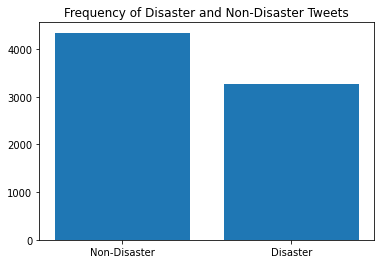

In [4]:
#need to get the corpus, count numer of words that are in disaster tweets, show # of disaster tweets, etc.
categories = train['target'].value_counts().index
count = train['target'].value_counts().values
plt.bar(categories, count)
plt.xticks(np.arange(0,1.1,step=1))
plt.xticks([0,1],['Non-Disaster','Disaster'])
plt.title('Frequency of Disaster and Non-Disaster Tweets')
plt.show()

In [5]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

There are more tweets about non-disasters (4,342) than about disasters (3,271), but the imbalance is not so great that it needs fixing. This also gives some sense of the baseline to beat: naively I could always guess that tweets are not about disasters and be right 57% of the time (4,342/(4,342+3,271)).

One thing that might be interesting to look at is the number of characters in the tweets. The next figure shows the frequency of different character counts. Twitter doubled their limit on characters from 140 to 280 back in 2017, nonetheless the distribution shows a peak at around 140 characters. This could be because the dataset has tweets from before the limit was raised.

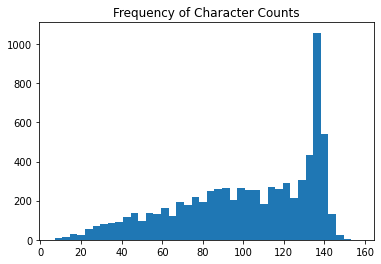

In [6]:
#show the number of characters in a tweet
plt.hist(train['text'].str.len(), bins=40)
plt.title('Frequency of Character Counts')
plt.show()

But do disaster and non-disaster tweets differ in length? The following table indicates that there is a slight differnce, at least in our sample. Disaster-related tweets were a bit longer. They also tended to have lower variance in the number of characters they contained. If anything, I would have expected disaster tweets to have a greater standard deviation, with people tweeting about disasters either reacting quickly and putting out minimal tweets to to inform others or writing long, detailed tweets to provide a lot of information.

In [7]:
targs = [0,1]
means = [np.mean(train[train['target'] == i]['text'].str.len()) for i in targs]
mins = [min(train[train['target'] == i]['text'].str.len()) for i in targs]
maxes = [max(train[train['target'] == i]['text'].str.len()) for i in targs]
sds = [np.std(train[train['target'] == i]['text'].str.len()) for i in targs]

pd.DataFrame({'Minimum':mins,'Mean':np.round(means,2),'Maximum': maxes, 'SD': sds}, index = ['Non-Disaster','Disaster'])

,Minimum,Mean,Maximum,SD
Non-Disaster,7,95.71,157,35.881791
Disaster,14,108.11,151,29.305374


We can also look at the word count in the tweets. Here words are being counted wherever there is a space between characters, and so might include symbols, numbers, and punctuation.

Disaster and non-disaster tweets look pretty similar with respect to word count. 

In [8]:
word_lengths = []
for i in train['text'].str.split():
  word_lengths.append(len(i))

lengths = pd.DataFrame({'Word Length':word_lengths,'Target':train['target']})
word_means = [np.mean(lengths[lengths['Target'] == i]['Word Length']) for i in targs]
word_sds = [np.std(lengths[lengths['Target'] == i]['Word Length']) for i in targs]
pd.DataFrame({'Average Words in Tweet':word_means,'SD':word_sds}, index = ['Non-Disaster',"Disaster"])

,Average Words in Tweet,SD
Non-Disaster,14.704744,6.160854
Disaster,15.167533,5.096027


How many unique words are there in the whole dataset? Again, counting words as just characters which are separated by spaces, there are 27,983 unique words.

In [9]:
corpus = []
new = train['text'].str.split()

new = new.values.tolist()
corpus = [word.lower() for i in new for word in i]

corpus = set(corpus)
len(corpus)

27983

It's time to do some more advanced EDA. It might be interesting to look at how frequently certain words appear. Obviously very common words (called "stop words") like "a" and "the" will be at the top of the list. Let's remove them. I download a set of stopwords from the NLTK package. After some experimenting, I realized that there are certain "words" like "http" which often show up in the tweets which should also be eliminated.

In [10]:
#Remove stop words
nltk.download('stopwords')
stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
stop.add('co')
stop.add('http')
stop.add('https')
stop.add('amp')
stop.add('û_')
stop.add('ûªs')
stop.add('ûª')
stop.add('gt')

With the stop words removed, what are some of the most common words we see? There are still a lot of numbers, with 2015 being the most common. Quite probably, many of the tweets came before Twitter increased its character limit.

In [12]:
vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
bag_of_words = vec.transform(corpus)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items() if (word not in stop)]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq[:20]

[('2015', 29),
 ('10', 24),
 ('08', 24),
 ('00', 22),
 ('11', 21),
 ('day', 19),
 ('disaster', 18),
 ('15', 18),
 ('ûï', 17),
 ('lt', 17),
 ('30', 16),
 ('year', 15),
 ('old', 15),
 ('16', 15),
 ('fire', 15),
 ('man', 15),
 ('time', 14),
 ('storm', 14),
 ('01', 14),
 ('news', 14)]

The `keyword` variable included in the training data is probably more useful. Here I look at the keywords for the non-disaster-related tweets. For not being about disasters, they contain a lot of disaster-related words. This probably reflect the attempt to construct a dataset that would be a machine learning challenge. Or the people on Twitter are overly dramatic. Perhaps both. 

For what it is worth, the most frequent keywords for disaster tweets are different (although still disaster-themed).

In [13]:
print('Frequency of keywords in non-disaster-related tweets:')
train['keyword'][train['target'] == 0].value_counts()[:20]

Frequency of keywords in non-disaster-related tweets:


body%20bags    40
harm           37
armageddon     37
wrecked        36
ruin           36
deluge         36
explode        35
twister        35
fear           35
siren          35
aftershock     34
panic          34
screaming      34
blizzard       33
blazing        33
blaze          33
crush          33
sinking        33
traumatised    33
curfew         32
Name: keyword, dtype: int64

We can also look at ngrams (the co-occurrence of words together). After some trial and error, I settled on showing the 20 most common four-grams. We can see some of the major disasters that are in the dataset: northern California fires, a suicide bomber, and what looks like Legionnaire's Disease. 

The idea and parts of the code here come from [1].

In [14]:
#ngrams
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:20]

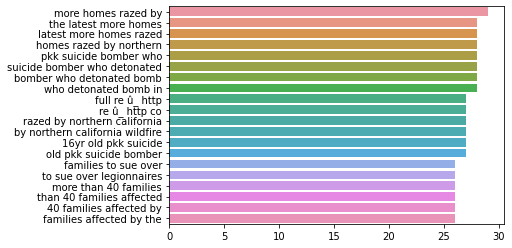

In [15]:
top_tri_grams=get_top_ngram(train['text'],n=4)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x);

Finally, it seemed like a shame not to use the location data. We can also try to look and see where the tweets were sent from. To do this, I installed the geocoder package, which allows for the latitude and longitude to be looked up from a location name.

In [ ]:
#pip install geocoder

     |████████████████████████████████| 98 kB 3.7 MB/s 


In [ ]:
#import geocoder

I then wrote a loop that went through the locations in the training data, searched for their coordinates on Bing, and if coordinates were found, saved the coordinates and the keyword of the tweet. Because Bing restricted the number of requests that could be made, the whole process took nearly 10 minutes to run. For that reason I commented out the code I used and simply wrote the results to a CSV.  

In [ ]:
'''coords = []
keywords = []
for i in range(len(train)):
  if str(train['location'][i]) != 'nan':
    result = geocoder.bing(train['location'][i], key='<private key>').json
    if result is not None:
      coords.append((result['lat'],result['lng']))
      keywords.append(train['keyword'][i])
'''

In [ ]:
#coordinates = pd.DataFrame(np.column_stack((keywords,coords)),columns=['keyword','latitude','longitude'])
#coordinates.to_csv('/content/gdrive/Othercomputers/My Laptop/Python/Disaster Tweets/coordinates.csv')

This is what the result looks like. Now I have the cordinates of the locations if Bing could find them. These results should be treated with caution - quite likely there were cases where the location intended is different than the location that Bing identified.

In [ ]:
coordinates = pd.read_csv('/content/gdrive/Othercomputers/My Laptop/Python/Disaster Tweets/coordinates.csv')
coordinates

,Unnamed: 0,keyword,latitude,longitude
0,0,ablaze,52.482899,-1.893462
1,1,ablaze,51.455315,-2.591902
2,2,ablaze,2.099101,17.294214
3,3,ablaze,39.951061,-75.165619
4,4,ablaze,51.500153,-0.126236
...,...,...,...,...
4148,4148,wrecked,45.659576,-110.563423
4149,4149,wrecked,37.254669,-119.617279
4150,4150,wrecked,55.865685,-4.257138
4151,4151,wrecked,40.753250,-74.003807


With the coordinates, we can now use the folium library to map out the coordinates. Rather than show all 4,153 locations at once, I wrote a function that would take in a list of keywords or randomly display the locations for n keywords. 

In [ ]:
import folium

In [ ]:
def show_events(keywords=[],random=False, n=1):
  #create a dictionary to hold the feature groups for each unique keyword
  feature_dict = dict()

  #create a list of the unique keywords to sample from
  kws = set(coordinates['keyword'])
  if random == True:
    import random
    keywords = list(random.sample(kws,n))

  #get rgb color scheme
  cmap = plt.get_cmap('inferno')
  colors = cmap(np.linspace(0, 1, len(keywords)))
  rgb_cols = []
  for i in colors:
    r = int(i[0] * 255)
    g = int(i[1] * 255)
    b = int(i[2] * 255)
    rgb_cols.append('%02x%02x%02x' % (r,g,b))

  #create map
  tweet_map = folium.Map(location = [0,0],zoom_start=3,tiles='stamentoner')
  for i in range(len(keywords)):
    feature_dict[keywords[i]] = colors[i], folium.map.FeatureGroup()

  #populate the map with markers
  for k in range(len(keywords)):
    for i in range(len(coordinates['keyword'])):
      if keywords[k] == coordinates['keyword'][i]:
        feature_dict[keywords[k]][1].add_child(folium.CircleMarker([float(coordinates['latitude'][i]),float(coordinates['longitude'][i])], radius = 4))
        folium.Marker([float(coordinates['latitude'][i]),float(coordinates['longitude'][i])],popup=folium.Popup(keywords[k]), icon=folium.Icon(color='black',icon_color='#'+rgb_cols[k])).add_to(tweet_map)

  return tweet_map

As an example, I ran the function, asking it to randomly pick 5 keywords to display. We can see they are "drowned," "bomb," "death," "bloody," and "buildings%20on%20fire". It would be easy to play around with this more, but let's move on to the neural network.

In [ ]:
show_events(random=True, n = 5)

## Data Preprocessing

With the EDA finished, I now want to split the training set in to training and validation sets so I can observe how the model does on classifying unseen tweets. I set the validation set to be 10% of the total. 

In [16]:
# train_test_split
from sklearn.model_selection import train_test_split

train_set, val_set = train_test_split(train, test_size=0.1, random_state=1)

print(train_set.shape)
print(val_set.shape)

(6851, 5)
(762, 5)


In [17]:
#set train and test sets and labels
x_train = train_set.iloc[:,:-1]
y_train = train_set.iloc[:,-1]

x_val = val_set.iloc[:,:-1]
y_val = val_set.iloc[:,-1]

There are 6,851 observations in the training set.

In [18]:
print(y_train.shape)
x_train

(6851,)


,id,keyword,location,text
3172,4551,emergency%20plan,Ireland,Our builder is having a dental emergency. Whic...
2188,3136,debris,"Berlin, Germany",Experts leave lab as Malaysia confirms debris ...
1554,2244,chemical%20emergency,NaN,Please stand up for bees against profit-hungry...
4485,6380,hostages,EastCarolina,#hot C-130 specially modified to land in a st...
2262,3242,deluged,Newcastle,Do you feel deluged by low self-image? Take th...
...,...,...,...,...
905,1308,bloody,NaN,All I need in this life of sin\nIs just me and...
5192,7413,obliterated,NaN,Drunk Meals 101: What To Cook When You're Tota...
3980,5656,flooding,"Kualar Lumpur, Malaysia",Monsoon Flooding Kills Dozens In Myanmar Promp...
235,335,annihilated,Û¢ Views From The Six Û¢,just completely annihilated cech with paul kee...


My primary model is going to be a Long Short Term Memory (LSTM) model with an embedding layer. I chose an LSTM because it is better than RNNs at holding long sequences in memory and generally have better performance than GRU's. For comparison I will also use BERT, a transofrmer model. 

The LSTM has two hyperparameters which I will tune: vocabulary size (which is the $n$ most common words which will be embedded) and the embedding dimensions, which is the number of dimensions that each word will have. The dimensions are a measure of how each word co-occurs with other words in the training set. 

The LSTM requires that all input sequences have be of the same length, so I will pad all sorter tweets with zeros so that they have the same number of tokens as the longest tweet (33 tokens).

In [37]:
#get maximum number of words in a tweet
maximum = 0
for i in training_sequence:
    if len(i) > maximum:
        maximum = len(i)
        
max_length = maximum
max_length

33

Below I create a function that will handle the entire process of building and training an LSTM model. The steps are, basically, to set the variables, including the two hyperparameters that I am tuning, tokenize the words in the text, pad the tweets to all be the same tokenized length, build, compile, and train the model, and finally plot the model's accuracy and loss.

I experimented with three different vocabulary sizes - 1,000, 10,000, and all of the words found in the training set and with three different embedding dimensions - 16, 32, and 64. 

I consistently found overfitting to be a big problem, even for the simpler models, and so I include a dropout layer in the model. Some experimentation (not displayed) indicated that a fairly high dropout rate yielded the best results. Below I set the rate to 0.8.


In [43]:
np.mean(history.history['val_accuracy'])

0.7534120708703995

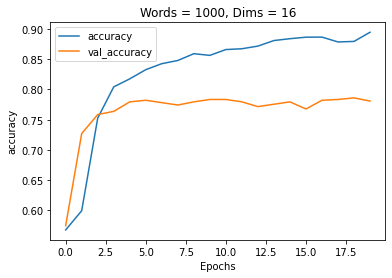

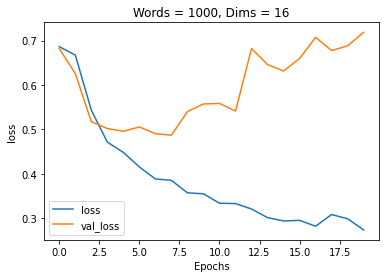

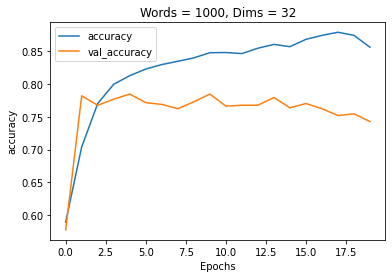

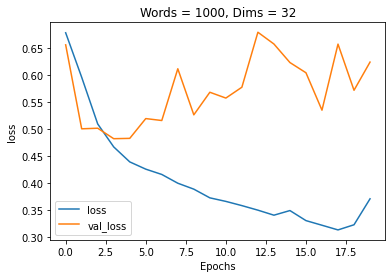

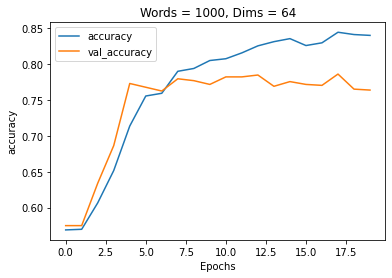

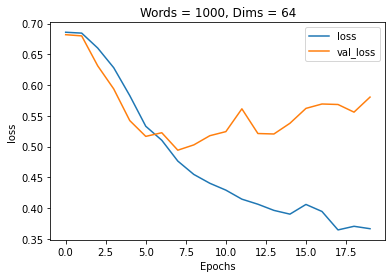

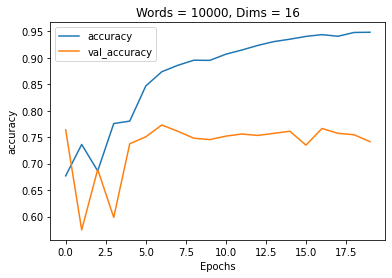

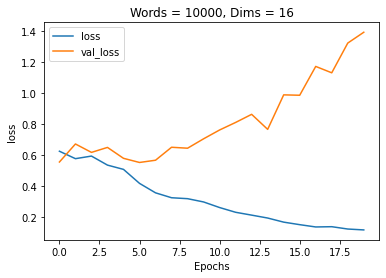

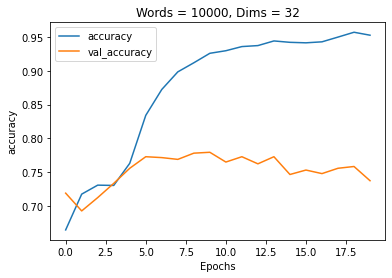

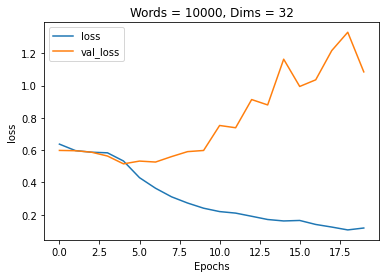

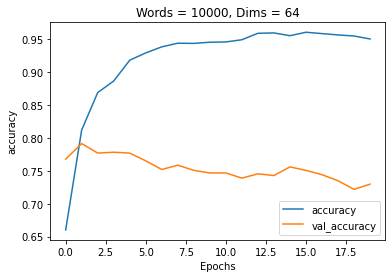

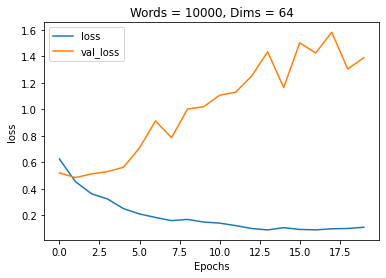

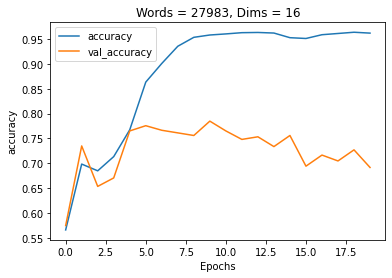

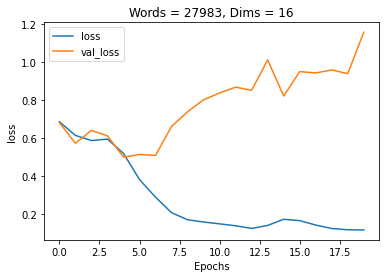

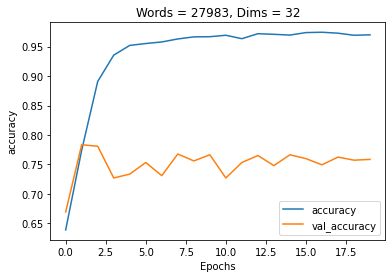

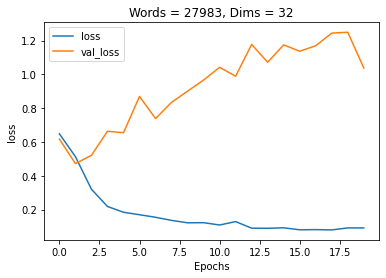

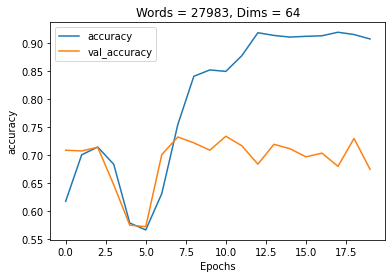

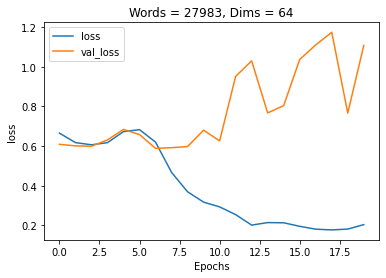

In [46]:
acc = []
val_acc = []
sizes = [1000, 10000, len(corpus)]
dims = [16, 32, 64]
num_epochs = 20

def LSTM_model(vocab_size, dimensions, epochs):
    # set variables
    vocab_size = size
    embedding_dim = dim
    padding_type='post'
    oov_tok = '<OOV>'

    # tokenize the text
    tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
    tokenizer.fit_on_texts(x_train['text']) 
    training_sequence = tokenizer.texts_to_sequences(x_train['text'])
    val_sequence = tokenizer.texts_to_sequences(x_val['text'])

    # pad the training and validation sequences and store them as np arrays
    training_padded = pad_sequences(training_sequence, padding = 'post', maxlen = max_length)
    val_padded = pad_sequences(val_sequence, padding = 'post', maxlen = max_length)
    training_padded = np.array(training_padded)
    training_labels = np.array(y_train)
    val_padded = np.array(val_padded)
    val_labels = np.array(y_val)

    # build model
    model = tf.keras.Sequential([
          tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
          tf.keras.layers.LSTM(16),
          tf.keras.layers.Dropout(0.8),
          tf.keras.layers.Dense(1, activation = 'sigmoid')
        ])
    
    # set optimizer and compile
    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

    # run the model for 20 epochs
    history = model.fit(training_padded, training_labels, epochs = num_epochs, 
                  validation_data = (val_padded, val_labels), verbose = 0)
        
    # plot the accuracy and loss
    title = f'Words = {size}, Dims = {dim}'
    plot_graph(history, 'accuracy', title)
    plot_graph(history, 'loss', title)

    # save each model's final accuracy and validation accuracy
    acc.append(np.mean(history.history['accuracy']))
    val_acc.append(np.mean(history.history['val_accuracy']))

for size in sizes:   
    for dim in dims:
        LSTM_model(size, dim, num_epochs)


As we can see from the graphs, overfitting was consistently a major problem, especially for the more complex models with a larger dimensionality and vocablary. It is a bit difficult to compare performance across all of the graphs, but looking at the average validation accuracy for each model indicates that the first model, with only 1,000 words and 16 dimensions, performed the best. This will be the model, then, that I use to generate predictions to submit to Kaggle.

In [47]:
val_acc

[0.7645669251680374,
 0.758858272433281,
 0.7425853043794632,
 0.7337926506996155,
 0.7529527574777604,
 0.7537401646375657,
 0.7266404181718826,
 0.7507873952388764,
 0.6917979031801224]

Just for fun, I want to take a look at the predictions the model makes for the test set. Below are the first 20 test set tweets and my model's predictions (above 0.5 indicates that the network would classify it as a disaster-related tweet).

The results look pretty good to me. It gets a tweet about lightning wrong. Somewhat humorously, it labels Nigerian Twitter being ablaze as a disaster, but not the Birmingham Wholesale Market being ablaze. So perhaps my network is not quite ready to be used to automatically notify emergency personnel.

In [ ]:
new_tweets = x_test['text'][:20]

seqs = tokenizer.texts_to_sequences(new_tweets)
padded = pad_sequences(seqs, maxlen = max_length, padding = 'post')

preds = (model.predict(padded))

for i in range(len(new_tweets)):
    print(new_tweets[i], preds[i])

Just happened a terrible car crash [0.9997895]
Heard about #earthquake is different cities, stay safe everyone. [0.9999275]
there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all [0.99996424]
Apocalypse lighting. #Spokane #wildfires [0.08919236]
Typhoon Soudelor kills 28 in China and Taiwan [0.8930113]
We're shaking...It's an earthquake [0.56264544]
They'd probably still show more life than Arsenal did yesterday, eh? EH? [0.07145137]
Hey! How are you? [0.07547587]
What a nice hat? [0.07334322]
Fuck off! [0.07117063]
No I don't like cold! [0.07247865]
NOOOOOOOOO! Don't do that! [0.37894544]
No don't tell me that! [0.68162566]
What if?! [0.09220877]
Awesome! [0.07323325]
Birmingham Wholesale Market is ablaze BBC News - Fire breaks out at Birmingham's Wholesale Market http://t.co/irWqCEZWEU [0.09138566]
@sunkxssedharry will you wear shorts for race ablaze ? [0.07091251]
#PreviouslyOnDoyinTv: Toke MakinwaÛªs marriage crisis sets Nigerian Twitter a

Now time to make the predictions for the contest and save them to a csv to submit.

In [ ]:
sequences = tokenizer.texts_to_sequences(x_test['text'])
padded = pad_sequences(sequences, maxlen = max_length, padding = 'post')

test_preds = (model.predict(padded))

In [ ]:
submission = pd.DataFrame({'id':x_test['id'],'target':[int(np.round(x,0)) for x in test_preds]})
submission.to_csv('/content/gdrive/Othercomputers/My Laptop/Python/Disaster Tweets/disaster_tweet_submission.csv')

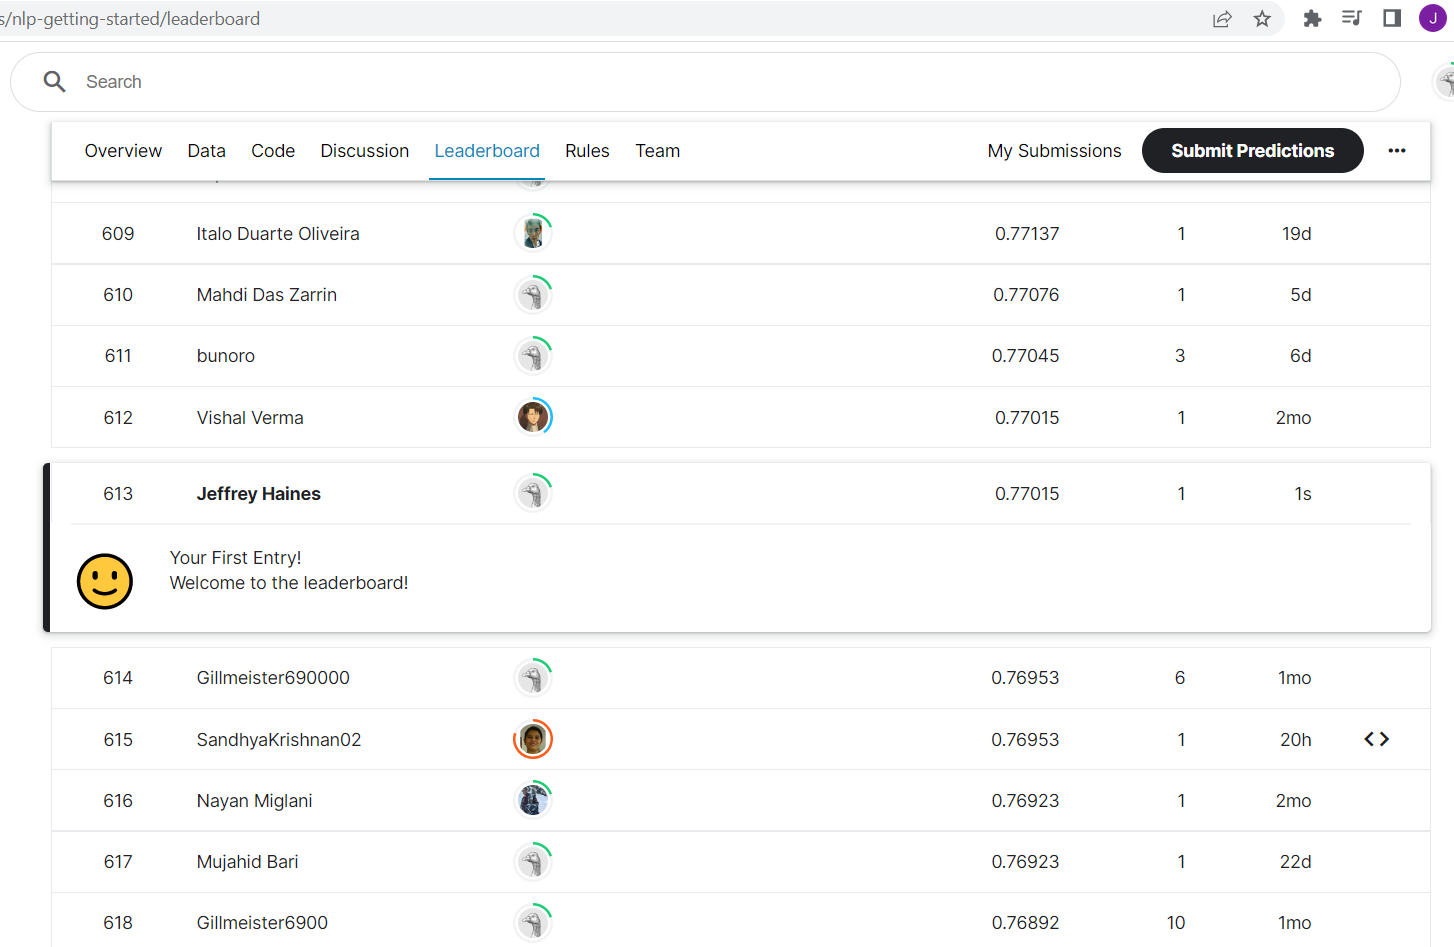

The LSTM performed respectably, but not fantastically, with a score of 0.77015, virtually identical to the validation accuracy. For comparison, I will also try using a more advanced transformer method, BERT. 

## Using BERT

In [1]:
#pip install tensorflow_text

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn import preprocessing

In [ ]:
preprocess_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
encoder_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

In [ ]:
# make the BERT layers
bert_preprocess = hub.KerasLayer(preprocess_url)
bert_encoder = hub.KerasLayer(encoder_url)

In [ ]:
# build the model with the functional API
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string, name = 'text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

x = tf.keras.layers.Dropout(0.1, name = 'dropout')(outputs['pooled_output'])
x = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'output')(x)

In [ ]:
#construct final model
model = tf.keras.Model(inputs = [text_input], outputs = [x])

In [ ]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
train_set, val_set = train_test_split(train, test_size=0.1, random_state=1)

x_train = train_set['text']
y_train = train_set.iloc[:,-1]

x_val = val_set['text']
y_val = val_set.iloc[:,-1]

y_train = np.array(y_train)
y_val = np.array(y_val)

In [ ]:
num_epochs = 20

history = model.fit(x_train, y_train, epochs = num_epochs, 
                    validation_data = (x_val, y_val), verbose = 2)


Epoch 1/20
215/215 - 78s - loss: 0.6350 - accuracy: 0.6504 - val_loss: 0.5988 - val_accuracy: 0.6312 - 78s/epoch - 362ms/step
Epoch 2/20
215/215 - 75s - loss: 0.5896 - accuracy: 0.6971 - val_loss: 0.5601 - val_accuracy: 0.7362 - 75s/epoch - 349ms/step
Epoch 3/20
215/215 - 74s - loss: 0.5797 - accuracy: 0.7075 - val_loss: 0.5787 - val_accuracy: 0.6850 - 74s/epoch - 344ms/step
Epoch 4/20
215/215 - 74s - loss: 0.5705 - accuracy: 0.7123 - val_loss: 0.5382 - val_accuracy: 0.7493 - 74s/epoch - 344ms/step
Epoch 5/20
215/215 - 74s - loss: 0.5552 - accuracy: 0.7272 - val_loss: 0.5648 - val_accuracy: 0.7310 - 74s/epoch - 344ms/step
Epoch 6/20
215/215 - 74s - loss: 0.5511 - accuracy: 0.7326 - val_loss: 0.5293 - val_accuracy: 0.7598 - 74s/epoch - 344ms/step
Epoch 7/20
215/215 - 74s - loss: 0.5426 - accuracy: 0.7419 - val_loss: 0.5307 - val_accuracy: 0.7546 - 74s/epoch - 342ms/step
Epoch 8/20
215/215 - 74s - loss: 0.5408 - accuracy: 0.7365 - val_loss: 0.5246 - val_accuracy: 0.7664 - 74s/epoch - 344

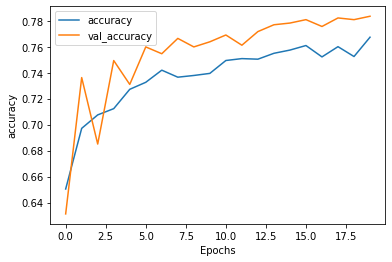

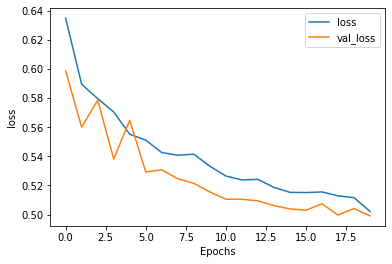

In [ ]:
plot_graph(history, "accuracy")
plot_graph(history, "loss")

In [ ]:
test_preds = (model.predict(x_test['text']))

102/102 [==============================] - 34s 319ms/step


In [ ]:
submission = pd.DataFrame({'id':x_test['id'],'target':[int(np.round(x,0)) for x in test_preds]})
submission.to_csv('/content/gdrive/Othercomputers/My Laptop/Python/Disaster Tweets/disaster_tweet_bert_submission.csv')

BERT is a slight improvement, but still was not able to crack the 0.8 ceiling. From the accuracy and loss plots it looks as though more training might continue to improve performance. Unfortunately, this was not the case training for 30 epochs (not pictured) resulted in no further gains over training for 20.

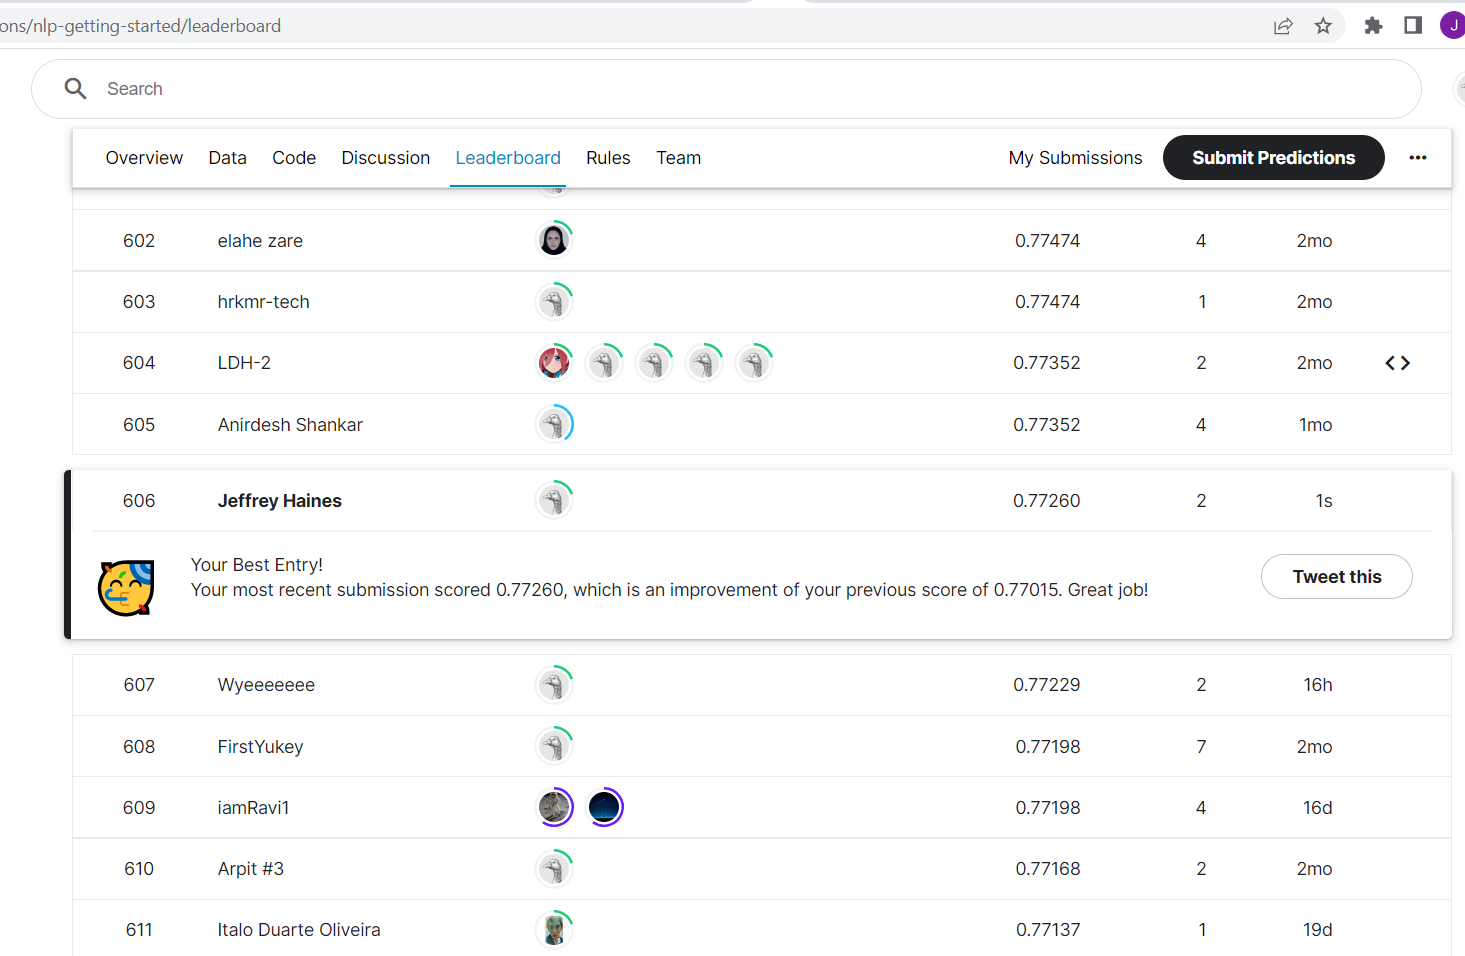

## Conclusion
Overall the LSTM model performed well, but there is much room for improvement. I had expected BERT to do better, as it is a more advanced and much hyped type of neural netwrok, but it performed nearly identically to the LSTM. Because of overfitting, using simpler models tended to result in the best performance. To improve performance, I might try a wider range of architectures, including bidirectional LSTMs and more dropout layers. This might enable me to capture more patterns in the data while preventing overfitting.


## References
[1] https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
